In [41]:
import sys, os
import importlib
from importlib import reload
# importlib.import_module(module_name)
sys.path.append("../../python")

import matplotlib.pyplot as plt
import numpy as np

from simhelper import util, root, generator, parser
from simhelper import datatypes
reload(parser)
reload(datatypes)

np.set_printoptions(edgeitems=30, linewidth=100000, 
    precision=3)

## Commands

./simulation -m../tests/filereader_generator/  
./digitizer data/run_0.root -s 1 -p 10  
./tracker data/run_0_digi.root -r data/run_0.root -k 1 -p 10  

In [1]:
fname_recon = "../../build/data/run_0_digi_recon.root"

In [8]:
f1 = root.tfile_reader(fname_recon)
f1.ls()
f1.get_tree("data")
f1.ls_tree()
# f1.get_entry(0)

None
Entries: 99
Branch: SimEntry            , Type: ['Int_t']
Branch: Track_x0            , Type: ['vector<float>']
Branch: Track_y0            , Type: ['vector<float>']
Branch: Track_z0            , Type: ['vector<float>']
Branch: Track_t0            , Type: ['vector<float>']
Branch: Track_kx            , Type: ['vector<float>']
Branch: Track_ky            , Type: ['vector<float>']
Branch: Track_kz            , Type: ['vector<float>']
Branch: Track_kt            , Type: ['vector<float>']
Branch: Track_cov           , Type: ['vector<float>']
Branch: Track_chi2          , Type: ['vector<float>']
Branch: Track_id            , Type: ['vector<int>']
Branch: Track_iv_ind        , Type: ['vector<int>']
Branch: Track_iv_err        , Type: ['vector<int>']
Branch: Track_digiInds      , Type: ['vector<int>']
Branch: Vertex_x0           , Type: ['vector<float>']
Branch: Vertex_y0           , Type: ['vector<float>']
Branch: Vertex_z0           , Type: ['vector<float>']
Branch: Vertex_t0          

In [32]:
data = f1.get_entry(0)
print(data.keys())

def process_recon(data):
    data["Digi_hitInds_unpacked"] = parser.unpack_at(data["Digi_hitInds"], divider=-1)
    data["Track_cov_unpacked"] = parser.unpack_cov(data["Track_cov"], dim=6)
    data["Track_digiInds_unpacked"] = parser.unpack_at(data["Track_digiInds"], divider=-1)
    data["Vertex_cov_unpacked"] = parser.unpack_cov(data["Vertex_cov"], dim=4)
    data["Vertex_trackInds_unpacked"] = parser.unpack_at(data["Vertex_trackInds"], divider=-1)

process_recon(data)

dict_keys(['SimEntry', 'Track_x0', 'Track_y0', 'Track_z0', 'Track_t0', 'Track_kx', 'Track_ky', 'Track_kz', 'Track_kt', 'Track_cov', 'Track_chi2', 'Track_id', 'Track_iv_ind', 'Track_iv_err', 'Track_digiInds', 'Vertex_x0', 'Vertex_y0', 'Vertex_z0', 'Vertex_t0', 'Vertex_cov', 'Vertex_chi2', 'Vertex_id', 'Vertex_trackInds', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_t', 'Digi_edep', 'Digi_trackID', 'Digi_pdgID', 'Digi_detectorID', 'Digi_type', 'Digi_hitInds', 'Digi_direction', 'Run_number', 'Evt_number', 'Seed_0', 'Seed_1', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_t', 'Hit_edep', 'Hit_px', 'Hit_py', 'Hit_pz', 'Hit_trackID', 'Hit_trackIDparent', 'Hit_pdgID', 'Hit_pdgIDparent', 'Hit_isprimary', 'Hit_processID', 'Hit_detectorID', 'Gen_x', 'Gen_y', 'Gen_z', 'Gen_t', 'Gen_px', 'Gen_py', 'Gen_pz', 'Gen_pdgID', 'Gen_index', 'Step_x', 'Step_y', 'Step_z', 'Step_t', 'Step_edep', 'Step_px', 'Step_py', 'Step_pz', 'Step_trackID', 'Step_trackIDparent', 'Step_pdgID', 'Step_status', 'Track_cov_unpacked', 'Track_digiInds_

2


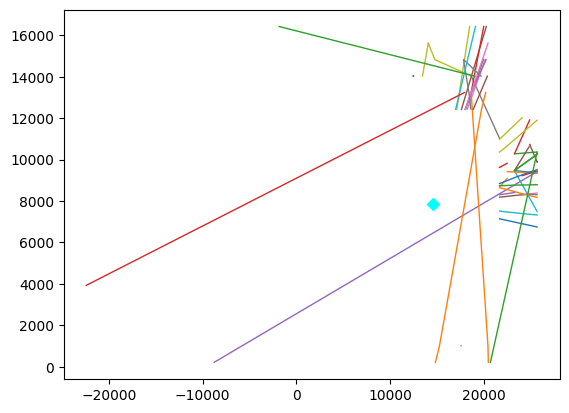

42


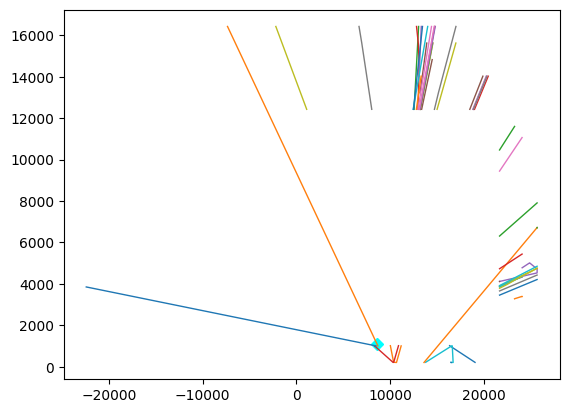

53


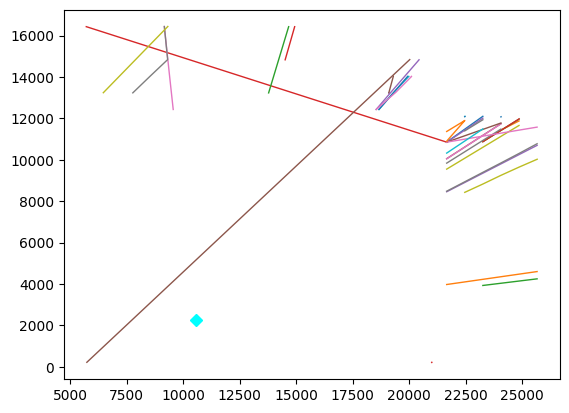

75


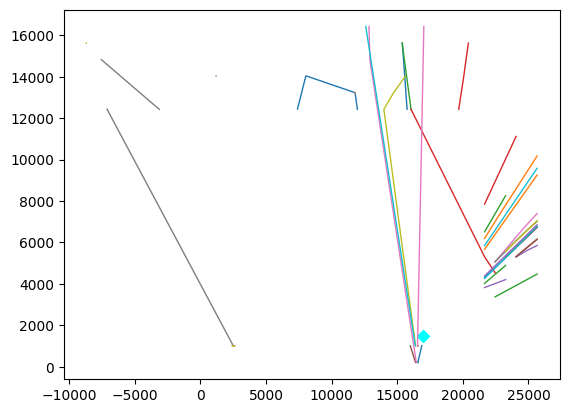

78


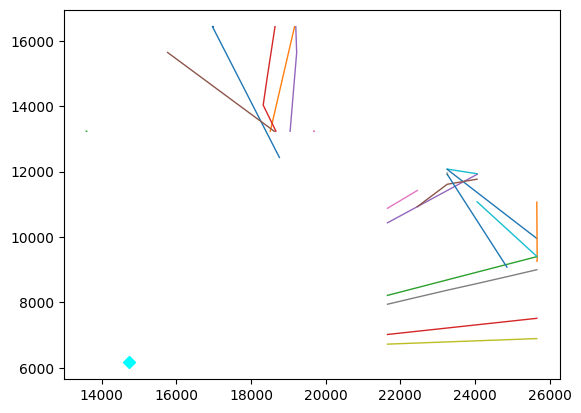

86


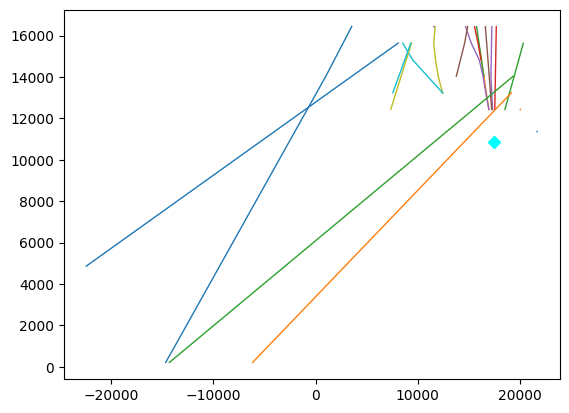

In [57]:
keys = ["track_nhits", "track_chi2", "track_residual_6d", "track_error_6d", "track_direction", "track_purity", "track_id", "track_pdg",
       "vertex_ntracks", "vertex_chi2", "event_vntrk_max"] 
res = {key:[] for key in keys}

isbreak=False
for i in range(f1.entries):
    
    data = f1.get_entry(i)
    process_recon(data)
    event = datatypes.Event(data)    

    for j in range(len(event.tracks)):
        t = event.tracks[j]
        res["track_residual_6d"].append(t.params - t.params_truth)
        res["track_error_6d"].append(np.sqrt(np.diagonal(t.cov)))
        res["track_direction"].append(t.iv_index)
        res["track_purity"].append(t.track_purity)
        res["track_id"].append(t.track_id)
        res["track_pdg"].append(t.track_pdg)
        res["track_nhits"].append(t.nhits)
        res["track_chi2"].append(t.chi2)
    
    ntracks=[]
    for j in range(len(event.vertices)):
        v = event.vertices[j]
        res["vertex_ntracks"].append(v.ntracks)
        ntracks.append(v.ntracks)

    if (len(ntracks)>0):
        res["event_vntrk_max"].append(np.max(ntracks))
    else:
        print(i)
        event.genvertices.plot(0,2)
        event.truetracks_plot(0,2)
        plt.show()
    

for key in res:
    res[key] = np.array(res[key])

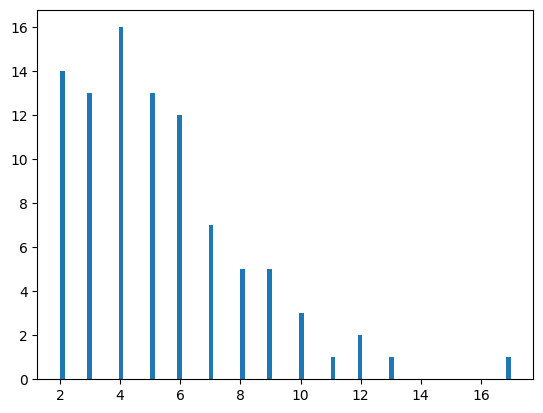

In [64]:
plt.hist(res["event_vntrk_max"],bins=100);

0.2661818181818182


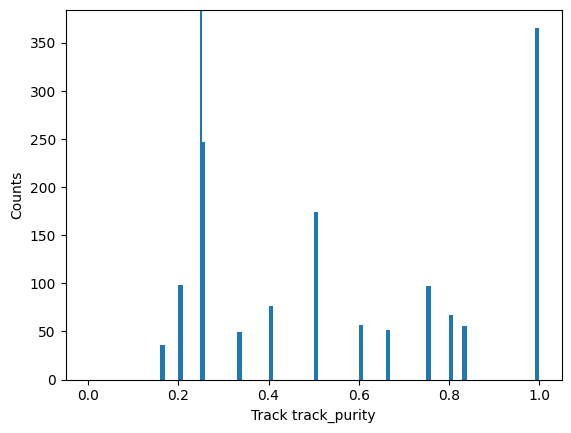

In [50]:
print(sum(res["track_purity"]==1)/len(res["track_purity"]))
plt.hist(res["track_purity"], bins=100,range=(0,1));
plt.xlabel("Track track_purity")
plt.ylabel("Counts")

plt.axvline(1/4)

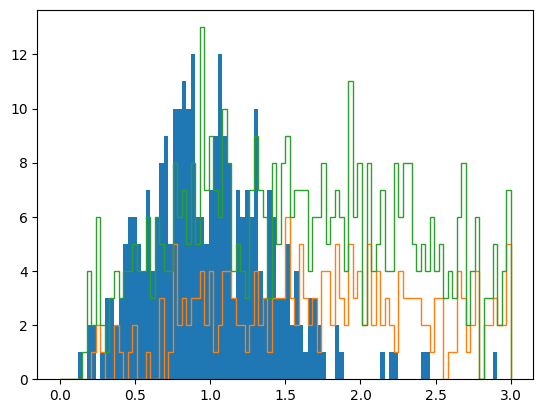

In [63]:
ndof = res["track_nhits"]*3-6

mask = (res["track_direction"]==2) & (res["track_purity"]==1)
plt.hist((res["track_chi2"]/ndof)[mask], bins=100,range=(0,3));
mask = (res["track_direction"]==2) & (res["track_purity"]==0.25)
plt.hist((res["track_chi2"]/ndof)[mask], bins=100,range=(0,3),histtype="step");
mask = (res["track_direction"]==2) & (res["track_nhits"]==4)
plt.hist((res["track_chi2"]/ndof)[mask], bins=100,range=(0,3),histtype="step");

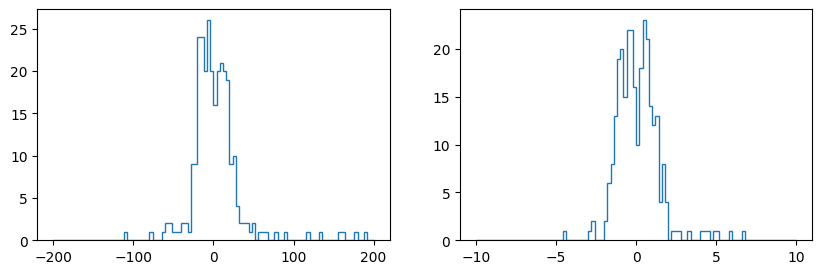

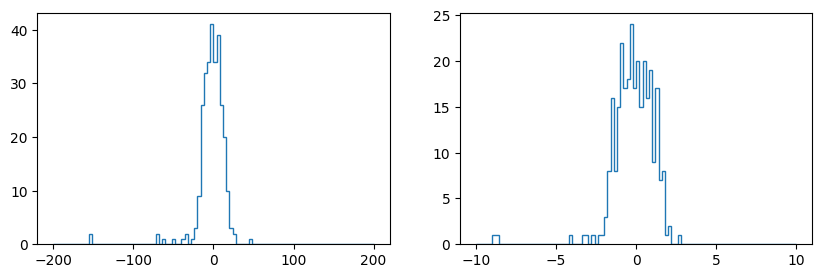

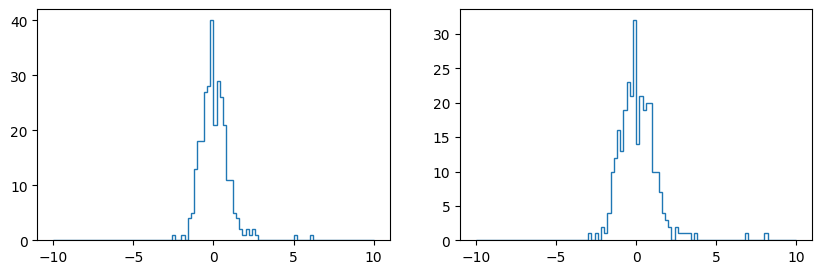

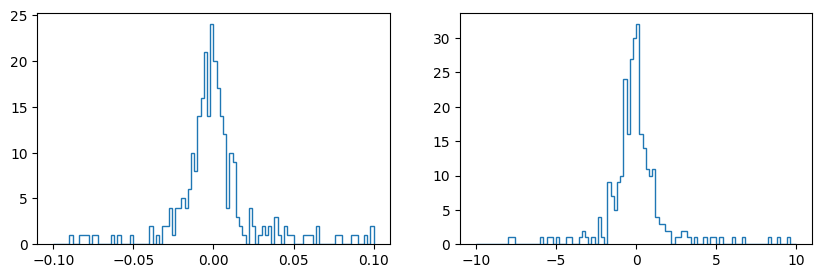

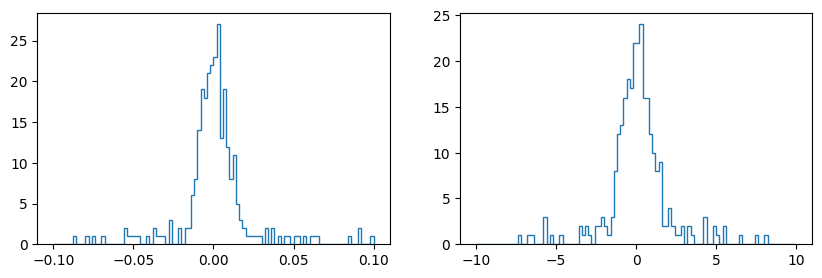

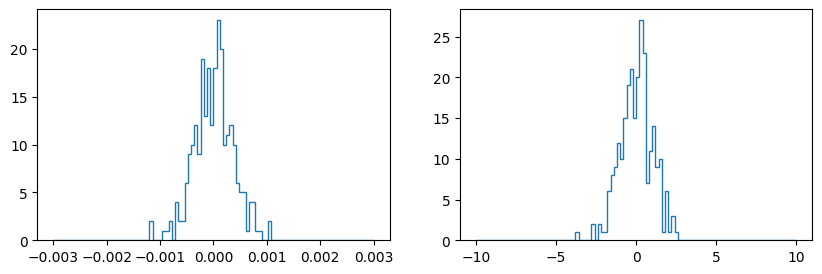

In [29]:
mask = (res["track_direction"]==2) & (res["track_purity"]==1)
plot_ranges = [[-200,200], [-200,200], [-10,10], [-0.1,0.1], [-0.1,0.1], [-0.003,0.003]]
plot_units = ["mm", "mm", "ns", "cm/cm", "cm/cm", "ns/mm"]
plot_labels = ["x", "y", "t", "kx", "ky", "kt"]

for i in range(6):
    fig,axs = plt.subplots(1,2,figsize=(10,3))
    plt.sca(axs[0])
    plt.hist((res["track_residual_6d"][:,i])[mask], bins=100, range=plot_ranges[i], histtype="step");
    plt.sca(axs[1])
    plt.hist((res["track_residual_6d"][:,i]/res["track_error_6d"][:,i])[mask], bins=100, range=(-10,10), histtype="step");
    plt.show()

# plt.hist(res["track_residual_6d"][:,5], bins=100,range=(-500,500));

In [323]:
def update_Q(dy, Ax, Az, At, multiple_scattering_p=500, multiple_scattering_length=0.06823501107481977):

    # precalculate some numbers
    Ax2 = Ax**2
    Az2 = Az**2
    At2 = At**2
    dy2 = dy**2
    P4P5 = (1+Ax2+Az2)
    P4P52 = P4P5*P4P5
    sin_theta = np.power(Ax**2+Az**2+1, -1/2)
    
    # Q_block1 = np.array([[(1+Ax2)*P4P5,      Ax*Az*P4P5 , Ax*P4P52*At],
    #                      [  Ax*Az*P4P5,    (1+Az2)*P4P5,  Az*P4P52*At],
    #                      [ Ax*P4P52*At,    Az*P4P52*At,   (Ax2+Az2)*P4P52*At2]])
    print(sin_theta)
    Q_block1 = np.array([[(1+Ax2)*P4P5,      Ax*Az*P4P5 , Ax*P4P5**0.5*At],
                         [  Ax*Az*P4P5,    (1+Az2)*P4P5,  Az*P4P52**0.5*At],
                         [ Ax*P4P5**0.5*At,    Az*P4P52**0.5*At,   (Ax2+Az2)*At2]])    
            
    Q = np.block([[Q_block1*dy2, Q_block1*dy],
                  [Q_block1*dy , Q_block1]])      

    sigma_ms2 = scattering_angle(multiple_scattering_length/sin_theta, momentum_MeV=multiple_scattering_p)**2
    print(sigma_ms2)
    
    Q = Q*sigma_ms2
    return Q


def update_Q_partial(dy, Ax, Az, At, multiple_scattering_p=500, multiple_scattering_length=0.06823501107481977):

    # precalculate some numbers
    Ax2 = Ax**2
    Az2 = Az**2
    At2 = At**2
    dy2 = dy**2
    P4P5 = (1+Ax2+Az2)
    P4P52 = P4P5*P4P5
    sin_theta = np.power(Ax**2+Az**2+1, -1/2)

    Q_block1 = dy2 * np.array([[(1+Ax2)*P4P5,      Ax*Az*P4P5 , Ax*P4P52*At],
                         [  Ax*Az*P4P5,    (1+Az2)*P4P5,  Az*P4P52*At],
                         [ Ax*P4P52*At,    Az*P4P52*At,   (Ax2+Az2)*P4P52*At2]])        

    sigma_ms2 = track.scattering_angle(multiple_scattering_length/sin_theta, momentum_MeV=multiple_scattering_p)**2

    Q_block1 = Q_block1*sigma_ms2
    return Q_block1        


def scattering_angle(l_rad_relative, momentum_MeV):
    sigma_ms = 13.6 * np.sqrt(l_rad_relative) * (1 + 0.038 * np.log(l_rad_relative)) / momentum_MeV; #
    return sigma_ms 


In [324]:
update_Q(10000, 0.1, 0.3, 0.003)

0.9534625892455922
4.286692975989267e-05


array([[4.763e+03, 1.415e+02, 1.349e+00, 4.763e-01, 1.415e-02, 1.349e-04],
       [1.415e+02, 5.140e+03, 4.244e+00, 1.415e-02, 5.140e-01, 4.244e-04],
       [1.349e+00, 4.244e+00, 3.858e-03, 1.349e-04, 4.244e-04, 3.858e-07],
       [4.763e-01, 1.415e-02, 1.349e-04, 4.763e-05, 1.415e-06, 1.349e-08],
       [1.415e-02, 5.140e-01, 4.244e-04, 1.415e-06, 5.140e-05, 4.244e-08],
       [1.349e-04, 4.244e-04, 3.858e-07, 1.349e-08, 4.244e-08, 3.858e-11]])

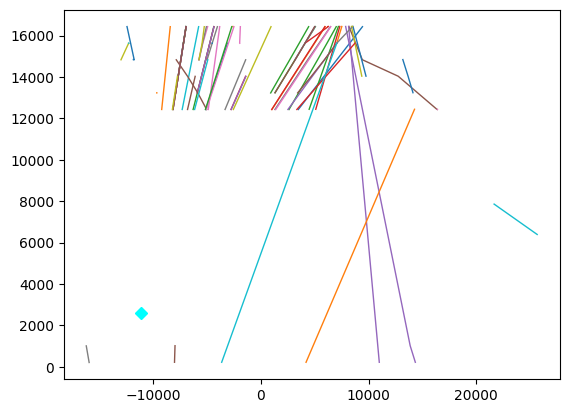

In [231]:
event.genvertices.plot(0,2)
event.truetracks_plot(0,2)

In [234]:
track.params, track.cov

(array([-6.172e+03,  1.488e+04,  3.603e+01,  3.062e-01, -1.312e-01,  3.564e-03]),
 array([[ 1.698e+00,  4.997e-06,  5.437e-04, -5.601e-04, -9.370e-09, -8.496e-07],
        [ 4.997e-06,  1.000e+00,  3.718e-08, -6.247e-09, -3.125e-04, -5.809e-11],
        [ 5.437e-04,  3.718e-08,  6.177e-01, -6.797e-07, -6.971e-11, -1.838e-04],
        [-5.601e-04, -6.247e-09, -6.797e-07,  3.095e-07,  1.171e-11,  1.062e-09],
        [-9.370e-09, -3.125e-04, -6.971e-11,  1.171e-11,  1.953e-07,  1.089e-13],
        [-8.496e-07, -5.809e-11, -1.838e-04,  1.062e-09,  1.089e-13,  9.192e-08]]))

In [118]:
def get_same_invar_pos_and_cov(point, track: Track):

    dt = point[track.iv_index] - track.params_full[track.iv_index];
    pos_on_track = track.params[:3] + track.params[3:] * dt;
    pos_full = np.insert(pos_on_track, track.iv_index, point[track.iv_index]);
    cov_residual = track.cov[:3, :3] + \
                   track.cov[:3, 3:] * dt +\
                   track.cov[3:, :3] * dt +\
                   track.cov[3:, 3:] * dt * dt;

    return pos_full, cov_residual

# def get_same_time_dist_and_chi2(Vector4d point, double speed_constraint):
#     auto point_and_cov = get_same_time_pos_and_cov(point, speed_constraint);
#     Vector3d residual = point_and_cov.first.segment(0,3) - point.segment(0, 3);
#     double dist_point = residual.norm();
#     double chi2_point = residual.transpose() * point_and_cov.second.inverse() * residual;

#     return std::make_pair(dist_point, chi2_point);


In [122]:
point = np.array([data["Gen_x"][0], data["Gen_y"][0], data["Gen_z"][0], data["Gen_t"][0]])
# point +=[8000,-5000,3000,1]
point

array([-11167.925,  14237.491,   2604.494,      0.   ])

In [171]:
track.GetTrack(data,6)
track.params, track.nhits, track.cov

(array([-7.450e+03,  1.435e+04,  3.565e+01,  5.469e-01,  6.562e-02,  3.754e-03]),
 4,
 array([[ 1.787e+00,  1.499e-06,  6.045e-04, -6.709e-04, -2.811e-09, -9.445e-07],
        [ 1.499e-06,  1.000e+00,  5.603e-09, -1.874e-09, -3.125e-04, -8.755e-12],
        [ 6.045e-04,  5.603e-09,  6.176e-01, -7.556e-07, -1.051e-11, -1.838e-04],
        [-6.709e-04, -1.874e-09, -7.556e-07,  4.481e-07,  3.514e-12,  1.181e-09],
        [-2.811e-09, -3.125e-04, -1.051e-11,  3.514e-12,  1.953e-07,  1.642e-14],
        [-9.445e-07, -8.755e-12, -1.838e-04,  1.181e-09,  1.642e-14,  9.192e-08]]))

In [169]:
3.095e-07  * 1e8 * 20

619.0

In [157]:
get_same_invar_pos_and_cov(point, track)

(array([-1.118e+04,  1.412e+04,  2.604e+03,  1.081e+01]),
 array([[3.739e+01, 4.282e-03, 6.159e-02],
        [4.282e-03, 1.173e+02, 3.362e-05],
        [6.159e-02, 3.362e-05, 2.357e+01]]))

In [113]:
cov=np.array([[    416.569,  -0.0036817,     1.26027],
            [ -0.0036817,     143.347, -1.2199e-05],
            [    1.26027, -1.2199e-05,     28.8281]])
residual=np.array([1112.66, 373.865, 1.02429])
residual.dot(np.linalg.inv(cov)).dot(residual)

3947.2493633909903

In [114]:
np.linalg.inv(cov)

array([[ 2.401e-03,  6.165e-08, -1.050e-04],
       [ 6.165e-08,  6.976e-03,  2.567e-10],
       [-1.050e-04,  2.567e-10,  3.469e-02]])